In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import chess
from sarfa import core, BoardVisualization, SarfaBaseline, Engine, RemovalPerturber, SarfaComputeResult, get_all_pos
from IPython.display import Image, display
from collections import defaultdict

# Configure Test

In [3]:
{"fen":"3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1","responseMoves":["Rxf7"],"saliencyGroundTruth":["f1","h2","c3","e1","b3","h7","g3","g7"],"solution":["Rxf7","Qxc7"]}

{'fen': '3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1',
 'responseMoves': ['Rxf7'],
 'saliencyGroundTruth': ['f1', 'h2', 'c3', 'e1', 'b3', 'h7', 'g3', 'g7'],
 'solution': ['Rxf7', 'Qxc7']}

In [4]:
FEN = "r2qrbk1/1bp2ppp/p2p1n2/2p2NB1/4P3/2N2Q2/PPP2PPP/R3R1K1 w - - 0 1"
action = None
DISCOUNT_FACTOR = 0.9
DEPTH = 1
RUNTIME=2.0

In [7]:
name = f"sarfa_sequential_{int(RUNTIME * 10)}_{int(DISCOUNT_FACTOR * 100)}_{DEPTH}"
name

'sarfa_sequential_20_90_1'

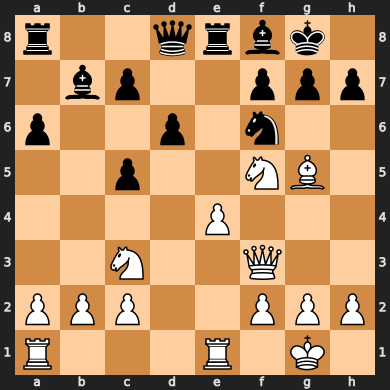

In [8]:
board = chess.Board(FEN)
board_visualization = BoardVisualization(board)
board_visualization.only_board()

# Algorithm Test

In [9]:
engine = Engine("./stockfish_15_x64_avx2")

def sequential_saliency_algorithm(fen, discount_factor, depth, runtime=2.0):
    saliency_results_per_step = []
    moves_taken = []
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    
    current_to_original_pos_mapping = {pos: pos for pos in get_all_pos()}

    for curr_step in range(0, depth):
        print(f"curr step: {curr_step}")
        saliency_calculator = SarfaBaseline(engine, board, runtime=runtime)
        
        optimal_move, optimal_move_q = None, 0
        saliency_results_timestep = defaultdict(int)

        for perturbed_board, perturbed_position_str in perturber.process():
            sarfa_compute_result: SarfaComputeResult = saliency_calculator.compute(perturbed_board, None)

            # update the optimal action for this depth
            # don't take an action that is coming from perturbation
            # leading to check
            if sarfa_compute_result.optimal_move_q_val != float("inf") and \
                (not optimal_move or sarfa_compute_result.optimal_move_q_val > optimal_move_q):
                optimal_move = sarfa_compute_result.optimal_move
                optimal_move_q = sarfa_compute_result.optimal_move_q_val
            
            perturbed_position_original_str = current_to_original_pos_mapping[perturbed_position_str]
            saliency_results[perturbed_position_original_str] += (sarfa_compute_result.saliency * (discount_factor ** curr_step))
            saliency_results_timestep[perturbed_position_original_str] += sarfa_compute_result.saliency
        if not optimal_move:
            print("no vaid move found")
            break
        saliency_results_per_step.append((saliency_results_timestep.copy(), board.copy()))

        # take optimal action on the current board
        # use this new board is the action for next iteration
        optimal_move_obj = chess.Move.from_uci(optimal_move)
        moves_taken.append(optimal_move_obj)
        board.push(optimal_move_obj)

        # update mapping
        if (not board.is_game_over()):
            start_move_pos = optimal_move[0:2]
            end_move_pos = optimal_move[2:4]
            current_to_original_pos_mapping[end_move_pos] = current_to_original_pos_mapping[start_move_pos]
        else:
            print("game finished early")
            break
    
    return saliency_results, saliency_results_per_step, moves_taken

## 2 Seconds

In [27]:
saliency_results_per_step = []
moves_taken = []

saliency_results, saliency_results_per_step, moves_taken = sequential_saliency_algorithm(FEN, DISCOUNT_FACTOR, DEPTH, runtime=2.0)

curr step: 0
a2
b2
b3
b6
b7
c3
c7
d8
e1
f1
f7
f8
g2
g3
g7
h2
h6
h7
curr step: 1
a2
b2
b3
b6
b7
c3
c7
d8
e1
f7
f8
g2
g3
g7
h2
h6
h7
curr step: 2
a2
b2
b3
b6
b7
c3
c7
d8
e1
f7
f8
g2
g3
g6
g7
h2
h7


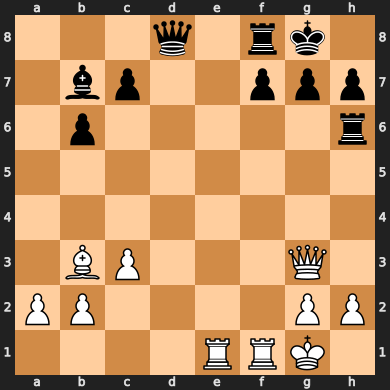

In [22]:
board

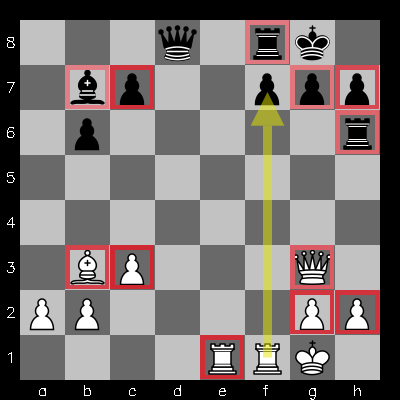

In [23]:
board_visualization = BoardVisualization(chess.Board(FEN))
path = board_visualization.show_heatmap(saliency_results, moves_taken[0])
display(Image(path))

In [24]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage

def show_progression(saliency_timestep, moves_taken: dict[int, chess.Move]):


    # Create a grid of subplots (1 row, 3 columns)
    fig, axes = plt.subplots(1, DEPTH, figsize=(15, 5))  # Adjust the size as needed

    # Loop through indices 1 through 3
    for step in range(DEPTH):  # 1 through 3 inclusive
        board_visualization = BoardVisualization(saliency_timestep[step][1])
        path = board_visualization.show_heatmap(saliency_timestep[step][0], moves_taken[step])
        img = PILImage.open(path)
        
        # Display the image in the corresponding subplot
        axes[step].imshow(img)
        axes[step].axis('off')  # Turn off axis
        axes[step].set_title(f"Timestep {step}", fontsize=12)

    # Adjust layout and show the grid
    plt.tight_layout()
    plt.show()


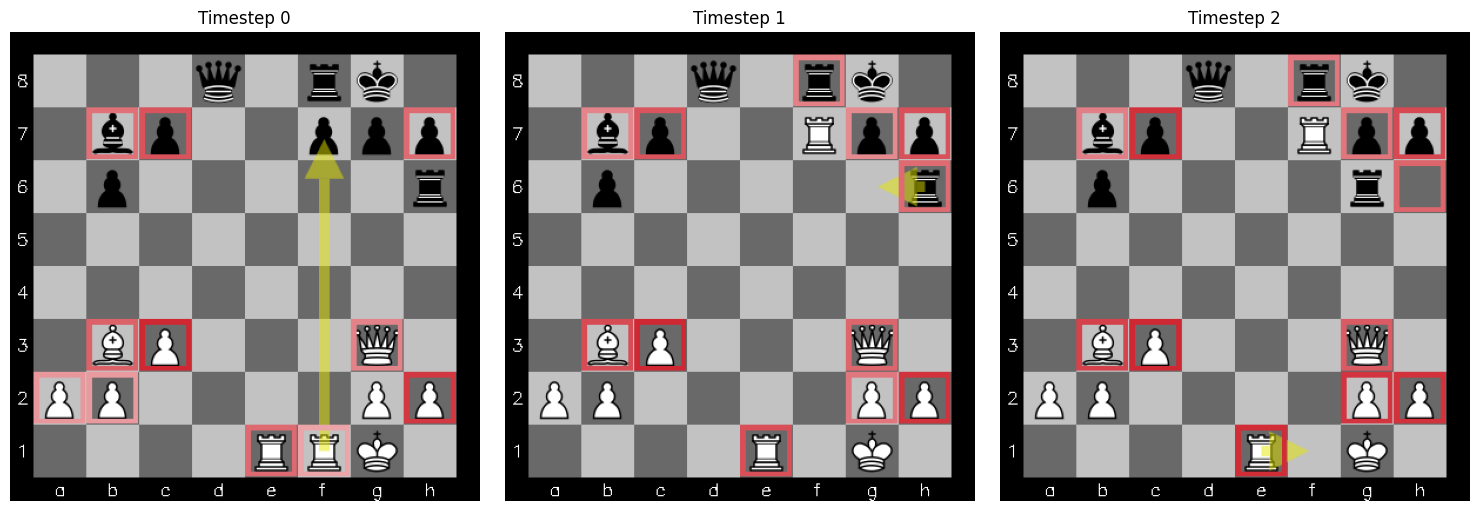

In [25]:
show_progression(saliency_results_per_step, moves_taken)

# Benchmark

In [10]:
from chess_dataset import SafraBenchmark
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [11]:
sequential_benchmark_function = lambda x, _: sequential_saliency_algorithm(x, DISCOUNT_FACTOR, DEPTH, RUNTIME)[0]


In [12]:
benchmark = SafraBenchmark.run(sequential_benchmark_function, name=name, sanity_check=False)

2r2rk1/pp1bqpp1/2nppn1p/2p3N1/1bP5/1PN3P1/PBQPPPBP/3R1RK1 w - - 0 1
curr step: 0


KeyboardInterrupt: 

# Analysis

In [8]:
sarfa_benchmark = SafraBenchmark.load_results(sequential_benchmark_function, name)

In [9]:
sarfa_benchmark.accuracy()

{'accuracy - harmonic_mean': 0.7143901852504448}

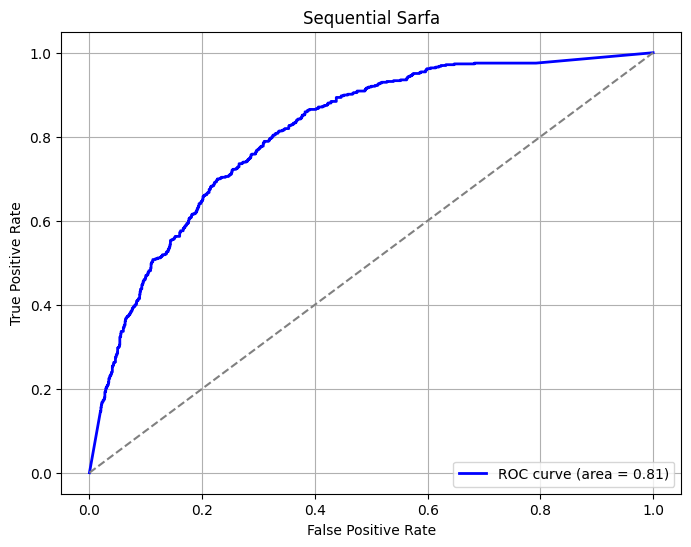

In [51]:
fig = sarfa_benchmark.plot_roc(name="Sequential Sarfa")
display(fig)